### Home work № 5:

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
                            precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler


%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть категориальные и вещественные признаки. Поле CustomerId нужно будет удалить.
Посмотрим на распределение классов:

In [3]:
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

распределение 1 к 4

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=42)

In [5]:
#соберем Pipeline
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [8]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([('selector', FeatureSelector(column=cat_col)),
                                ('ohe', OHEEncoder(key=cat_col))])
    final_transformers.append((cat_col, cat_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([('selector', NumberSelector(key=cont_col))])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [9]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Построим модели

In [10]:
pipeline_rf = Pipeline([('features',feats),
                        ('classifier', RandomForestClassifier(random_state = 42))])

pipeline_xgb = Pipeline([('features',feats), 
                         ('classifier', xgb.XGBClassifier(random_state = 42))])

pipeline_logreg = Pipeline([('features',feats), 
                            ('classifier', LogisticRegression(random_state = 42))])

In [11]:
params_rf = dict(classifier__n_estimators=[200, 500, 800],
                 classifier__max_depth=[6, 8, 12])
params_logreg = dict(classifier__C=[0.5, 1, 10, 100])
params_xgb = dict(classifier__n_estimators=[100, 200, 300],
                 classifier__max_depth=[2, 3, 4, 6])

Масштабируем данные для логистической регрессии

In [12]:
scaler_std = StandardScaler()

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

X_train_norm[continuous_columns] = scaler_std.fit_transform(X_train_norm[continuous_columns])
X_test_norm[continuous_columns] = scaler_std.transform(X_test_norm[continuous_columns])

Объединим поиск параметров и кросс-валидацию

In [13]:
def find_parameters(pipe, params, X_train, y_train):
    
    rs = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=5)  # Тут же делаем кросс-валидацию
    rs.fit(X_train, y_train.values.ravel())
    
    print(f"Model: {pipe['classifier']},\n params: {rs.best_params_},\n best_score: {rs.best_score_}\n\n")

In [14]:
%%time
find_parameters(pipeline_rf, params_rf, X_train, y_train)

Model: RandomForestClassifier(random_state=42),
 params: {'classifier__max_depth': 12, 'classifier__n_estimators': 500},
 best_score: 0.8556638411923645


Wall time: 1min 22s


In [15]:
%%time
find_parameters(pipeline_logreg, params_logreg, X_train_norm, y_train)

Model: LogisticRegression(random_state=42),
 params: {'classifier__C': 0.5},
 best_score: 0.7609850300706006


Wall time: 888 ms


In [16]:
%%time
find_parameters(pipeline_xgb, params_xgb, X_train, y_train)

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42,
              reg_alpha=None, reg_lambda=None, ...),
 params: {'classifier__max_depth': 2, 'classifier__n_estimators': 100},
 best_score: 0.85939488363985


Wall time: 33.4 s


In [17]:
pipeline_rf = Pipeline([('features',feats),
                        ('classifier', RandomForestClassifier(max_depth=12, n_estimators=500, random_state=42))])

pipeline_logreg = Pipeline([('features',feats),
                            ('classifier', LogisticRegression(C=0.5, random_state=42))])

pipeline_xgb = Pipeline([('features',feats),
                         ('classifier', xgb.XGBClassifier(max_depth=2, n_estimators=100, random_state=42))])

In [18]:
%%time

#обучим пайплайн на всем тренировочном датасете
def fit_predict_models(pipe, X_train, y_train, X_test):
    pipe.fit(X_train, y_train)
    y_score = pipe.predict_proba(X_test)[:, 1]
    return y_score

y_score_logreg = fit_predict_models(pipeline_logreg, X_train_norm, y_train, X_test_norm)
y_score_xgb = fit_predict_models(pipeline_xgb, X_train, y_train, X_test)
y_score_rf = fit_predict_models(pipeline_rf, X_train, y_train, X_test)

Wall time: 3.11 s


In [19]:
def metrics_calculation(y_test, preds, b=1):
    roc_auc = roc_auc_score(y_test, preds)
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    ix = np.nanargmax(fscore)
    return thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc

In [20]:
all_preds = [y_score_logreg, y_score_xgb, y_score_rf]
metrics = []
for preds in all_preds:
    best_threshold, fscore, precision, recall, roc_auc = metrics_calculation(y_test, preds, b=0.7)  
    # приоретизируем precision - обеспечим максимальное содержание TP в предсказаниях модели,
    # а следовательно не будем тратить неэффективно бюджет на FP
    metrics.append([best_threshold, fscore, precision, recall, roc_auc])
metrics = np.array(metrics)

<ipython-input-19-339a8e1e6516>:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)


In [21]:
metrics_comparison_df = pd.DataFrame(np.array(metrics[:, 1:]),
                   columns=['fscore', 'precision', 'recall', 'roc_auc'],
                   index=['y_score_logreg', 'y_score_xgb', 'y_score_rf'])
metrics_comparison_df

,fscore,precision,recall,roc_auc
y_score_logreg,0.499123,0.513100,0.472837,0.773439
y_score_xgb,0.654418,0.742210,0.527163,0.866775
y_score_rf,0.659808,0.725131,0.557344,0.865946


In [22]:
xhb_threshold = metrics[1, 0]  # запишем оптимальный порог для построения confusion_matrix

Отрисуем матрицу ошибок

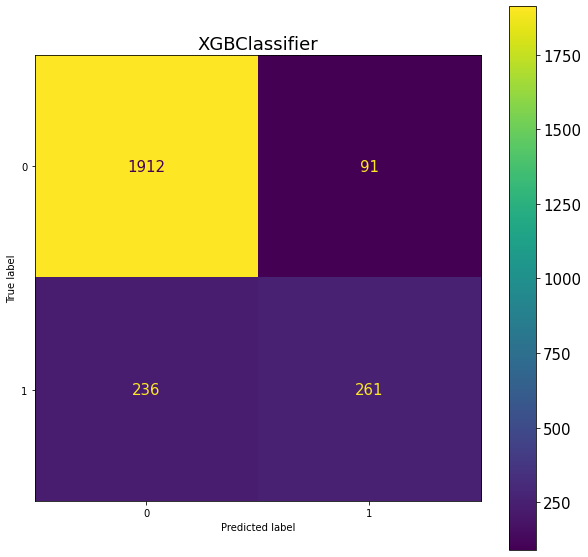

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
font = {'size' : 15}
plt.rc('font', **font)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_score_xgb>xhb_threshold))
disp.plot(ax=axes)
disp.ax_.set_title('XGBClassifier')
plt.subplots_adjust(wspace=1, hspace=0.1)
plt.savefig("confusion_matrix.jpg")
plt.show()

In [24]:
economic_profit=261*2-(261+91)*1
print(f'Экономическая эффективность модели {economic_profit}$')

Экономическая эффективность модели 170$
